# Geometry tutorial: part 1

One of the crucial parts of our framework is a `Geometry` class that holds information about the underlying cube of amplitudes in different data formats (**SEG-Y**, **HDF5**) and their versions with compression using quantization (**QSGY**, **QHDF5**). The main capabilities of `Geometry` are:

- infer information about traces in the cube based on one or more headers
- collect spatial and integral statistics about amplitude values
- provide methods for loading actual data from the desired location
- convert **SEG-Y** cubes to more efficient file formats that take less disk space

To create a `Geometry` instance for a **SEG-Y** cube, we need to supply a path to the cube and the headers that would be used to uniquely identify each of the traces: those headers are used as an index to access underlying data. Note that we only load more than one trace into memory when we specifically ask for it: all information collection is done sequentially, without requiring too much RAM.

The `Geometry` tutorial is split into two parts. The **first part** demonstrates a number of methods and properties that help us to **examine the geology**:

* [Post-stack cube with INLINE_3D/CROSSLINE_3D headers](#headers)
* [First look at geological properties](#stats)
* [Loading cube data slices](#cube_slices)

And in the [**second part**](./01_Geometry_part_2.ipynb) you will learn more about **different data formats** and **saving processed data**.

In [1]:
# All the necessary imports
import os
import sys
import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '../..')
sys.path.insert(0, '..')
from seismiqb import Geometry, plot

FIGURE_SCALE = 1.5

<a id='headers'></a>
# Post-stack: INLINE_3D/CROSSLINE_3D headers

First of all, we instantiate a cube. Besides cube location on the disk, we need to specify:

- headers to store for each trace
- which of the headers are used as a unique identifier of a trace: it must be a subset of `headers`
- whether to collect amplitude statistics and spatial stats

Post-stack is a cube after multiple processing steps: it is already summed, and each trace has a dedicated `INLINE_3D` and `CROSSLINE_3D`.

By default, we load  `INLINE_3D, CROSSLINE_3D, CDP_Y, CDP_X` headers and use the first two for indexing.

In [2]:
%%time
geometry = Geometry.new(path='/data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy',
                        collect_stats=True, recollect_stats=True)

print(geometry)

Processed geometry for cube        /data/seismic_data/seismic_interpretation/001_YETYPUR/001_YETYPUR.sgy
Index headers:                     ['INLINE_3D', 'CROSSLINE_3D']
Traces:                            3_611_267
Shape:                             (2563, 1409, 1501)
Time delay:                        50 ms
Sample rate:                       2.0 ms
Area:                              1522.4 km²

File size:                         21.000 GB
Instance (memory) size:            0.141 GB

Number of dead  traces:            1_175_447
Number of alive traces:            2_435_820
Fullness:                          0.67

Value statistics:
mean | std:                              0.03 | 1887.17   
min | max:                          -47429.45 | 39240.19  
q01 | q99:                           -5459.50 | 5118.29   
Number of unique values:                  214
CPU times: user 1min 35s, sys: 11.1 s, total: 1min 46s
Wall time: 18.7 s


A ```Geometry``` instance contains some information about the cube.
The following properties are available through the ```print``` call:
 * **Base info**: cube name, index headers, shape;
 * Info about **data acquisition**: time delay, sample rate;
 * **Сomputed info**: approximate area in squared kilometers;
 * **Storage** parameters;
 * **Traces info**: total amount, amount of meaningful traces and their proportion;
 * **Cube statistics** based on subsample of traces.

Moreover, this is not all what ```SeismicGeometry``` stored inside. We can save and get other things from an instance of this class:
 * Other **geometry properties** like depth, ranges, dead traces and area;
 * **Statistical matrices**: mean, std, min, max;
 * **Signal-to-noise** ratio matrix;

A regular `pandas` dataframe describes cube structure, storing all required headers:

In [3]:
geometry.headers

,CROSSLINE_3D,CDP_Y,INLINE_3D,CDP_X,TRACE_SEQUENCE_FILE
0,19,7150315,24,717115,1
1,20,7150315,24,717140,2
2,21,7150315,24,717165,3
3,22,7150315,24,717190,4
4,23,7150315,24,717215,5
...,...,...,...,...,...
3611262,1423,7214365,2586,752215,3611263
3611263,1424,7214365,2586,752240,3611264
3611264,1425,7214365,2586,752265,3611265
3611265,1426,7214365,2586,752290,3611266


***Note that our class can work with any indexing headers, not only the `INLINE_3D`/`CROSSLINE_3D` pair. Though, it is much preferred: those headers are represented by integer values, and their usage as an index is much more robust. A common flaw of a `CDP_X`/`CDP_Y` index is that multiple `CDP_X` can correspond to one `CROSSLIN_3D`. For example, `10.25`, `10.2501` values can be labeled as the first crossline, which makes the unique indexing much harder to impose.***

<a id='stats'></a>
# First look at geological properties

`INLINE_3D`/`CROSSLINE_3D` index provides a clear spatial structure, so we can collect spatial (lateral) stats at initialization. It takes some time and creates several additional attributes:

- `min_matrix`, `max_matrix`, `mean_matrix`, `std_matrix` store minimum, maximum, average, and variance values for each of the cube traces
- `min_vector`, `max_vector`, `mean_vector`, `std_vector` store minimum, maximum, average, and variance values depthwise

Each `*_matrix` has the same dimensionality as the spatial range of the cube: we can see that the cube has 2563 inlines and 1409 crosslines, and each matrix has the same shape. Most of the cubes are padded with zero traces on the edges to have a rectangular shape:

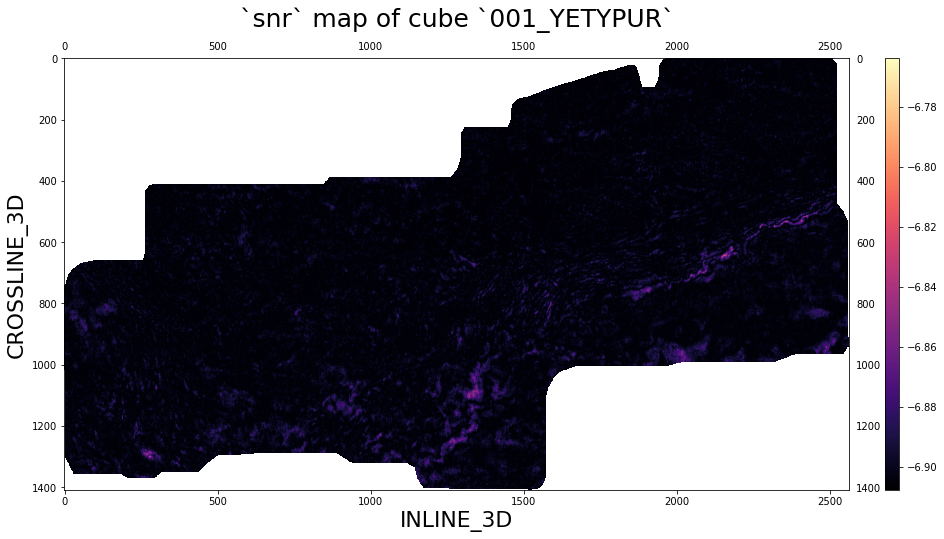

In [4]:
geometry.show(matrix='snr', scale=FIGURE_SCALE)

To speed up the instance initialization, we keep all of the collected stats near the cube in a ```*.sgy_meta``` file in HDF5 format and use it for subsequent initializations. To force re-creation of ```*.sgy_meta``` file (instead of loading stats from it) during processing, pass `recollect_stats=True` at initialization, just as we did.

<a id='cube_slices'></a>
# Loading cube data slices

One of the main usages of `Geometry` is to load slices of amplitudes. We use the `load_slide` method, which takes a number of a slice that we want to load. The loading acts along the specified axis (0 by default), corresponding to a `INLINE_3D` in our case. 

In [5]:
%%time
slide = geometry.load_slide(index=30, axis=0)

CPU times: user 5.89 ms, sys: 394 µs, total: 6.28 ms
Wall time: 4.64 ms


In [6]:
%%time
locations = [slice(0, 100), slice(600, 800), slice(600, 1000)]
crop = geometry.load_crop(locations)

CPU times: user 19.3 ms, sys: 23.9 ms, total: 43.2 ms
Wall time: 42.6 ms


For convenience, the square brackets allow working with an instance of `geometry` like with any regular 3D array and load data into memory. As you can see, loading an entire ~20GB cube takes just a few seconds!

In [7]:
%%time
print(f"Entire cube:\n    {geometry.shape}\n    {geometry[:, :, :].shape}\n")

Entire cube:
    [2563 1409 1501]
    (2563, 1409, 1501)

CPU times: user 7.78 s, sys: 7.1 s, total: 14.9 s
Wall time: 14.9 s


In [8]:
%%time
print(f"Crop:\n    {geometry[700:900, 200:600, 0:30].shape}\n")
print(f"Slide:\n    {geometry[100, :].shape}\n    {geometry[:, 10].shape}\n    {geometry[:, :, 0].shape}\n")

Crop:
    (200, 400, 30)

Slide:
    (1409, 1501)
    (2563, 1501)
    (2563, 1409)

CPU times: user 2.27 s, sys: 150 ms, total: 2.42 s
Wall time: 2.41 s


# Visualization

Method `show_slide` acts exactly like `load_slide` does and works with the same parameters, but displays the data instead of returning it.

***Note:*** just like any other plot in our library, it automatically parses `matplotlib` arguments and uses them in right places. To learn more about it, check out our [plotting tutorial](./plotters/01_image.ipynb)! 

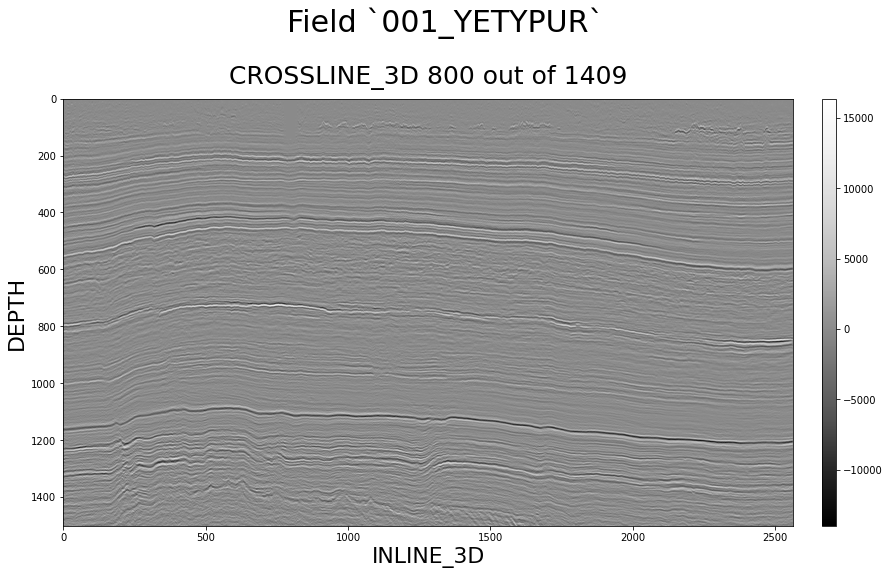

In [9]:
geometry.show_slide(index=800, axis=1, scale=FIGURE_SCALE)

As the bottom of the slide is very noisy and does not provide much insight, we would like to zoom in. `zoom` parameter does exactly that:

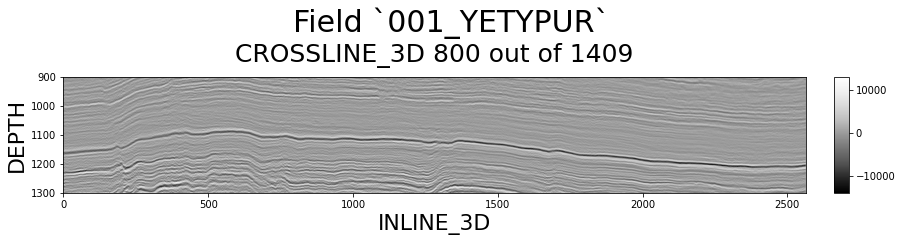

In [10]:
geometry.show_slide(index=800, axis=1, scale=FIGURE_SCALE,
                    zoom=(slice(None), slice(900, 1300)))

Sometimes, change of colormap helps to distinguish reflections such as horizons and faults:

***We also zero-center the image by passing `vmin` and `vmax` values.***

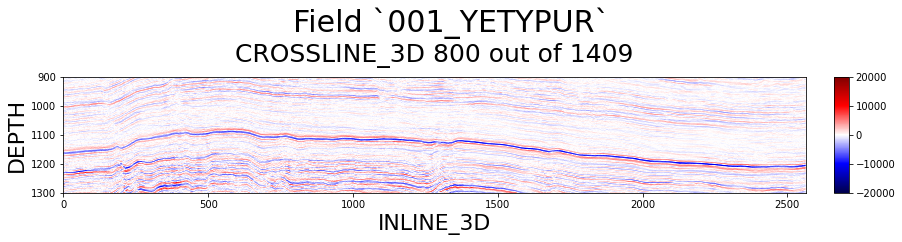

In [11]:
geometry.show_slide(index=800, axis=1, scale=FIGURE_SCALE,
                    zoom=(slice(None), slice(900, 1300)),
                    cmap='seismic', vmin=-20000, vmax=20000)

# Conclusion

This concludes the **first part** of the `SeismicGeometry` tutorial: it showed how to dive into geological data with the `SeismicGeometry` class. Specifically, you have learned how to:

- infer geological properties like SNR of seismic cubes
- load actual slices of seismic data, as well as visualize them
- display simple amplitude distribution statistics

The [second part](./01_Geometry_part_2.ipynb) shows data loading optimizations and saving new data cubes.